### **Mounting data and importing libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/DA621_DL_with_CV') #path in my google drive where I've uploaded the dataset

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.ndimage import uniform_filter
from sklearn.metrics import classification_report, accuracy_score
from six.moves import cPickle as pickle
import os
from data_utils import load_CIFAR10

%matplotlib inline
%load_ext autoreload
%autoreload 2

Dataset was uploaded to my google-drive and fetched from there

In [4]:
data_dir = '/content/drive/MyDrive/DA621_DL_with_CV/datasets/cifar-10-batches-py'

x_train, y_train, x_test, y_test = load_CIFAR10(data_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [5]:
#Reducing the training and testing dataset size to speed up the model training on colab environment

num_training = 3000
mask = list(range(num_training))
X_train = x_train[mask]
y_train = y_train[mask]

num_test = 1000
mask = list(range(num_test))
X_test = x_test[mask]
y_test = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(3000, 3072) (1000, 3072)


# **KNN-Classifier Implementation**

In [7]:
class KNN(object):

  def __init__(self):
    pass

  def train(self, X, y):
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1):
    dists = self.compute_distances(X)
    return self.predict_labels(dists, k=k)

  def compute_distances(self, X):
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in range(num_test):
      for j in range(num_train):
        dists[i][j] = np.sqrt(np.sum((X[i] - self.X_train[j])**2))
    return dists

  def predict_labels(self, dists, k=1):
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in range(num_test):
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i])][0:k]
      y_pred[i] = np.bincount(closest_y).argmax()
      
    return y_pred

In [8]:
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

In [9]:
knn_classifier = KNN()
knn_classifier.train(X_train, y_train)

In [10]:
dists = knn_classifier.compute_distances(X_test)
print(dists.shape)

(1000, 3000)


In [11]:
k=1
y_test_pred = knn_classifier.predict_labels(dists, k)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct at k=%d => accuracy: %f' % (num_correct, num_test, k, accuracy))

Got 248 / 1000 correct at k=1 => accuracy: 0.248000


### **Finding the best value of k .......**


k = 1, accuracy = 0.248000
k = 3, accuracy = 0.251000
k = 5, accuracy = 0.273000
k = 8, accuracy = 0.266000
k = 10, accuracy = 0.268000
k = 12, accuracy = 0.263000
k = 15, accuracy = 0.258000
k = 20, accuracy = 0.254000
k = 50, accuracy = 0.241000
k = 100, accuracy = 0.238000


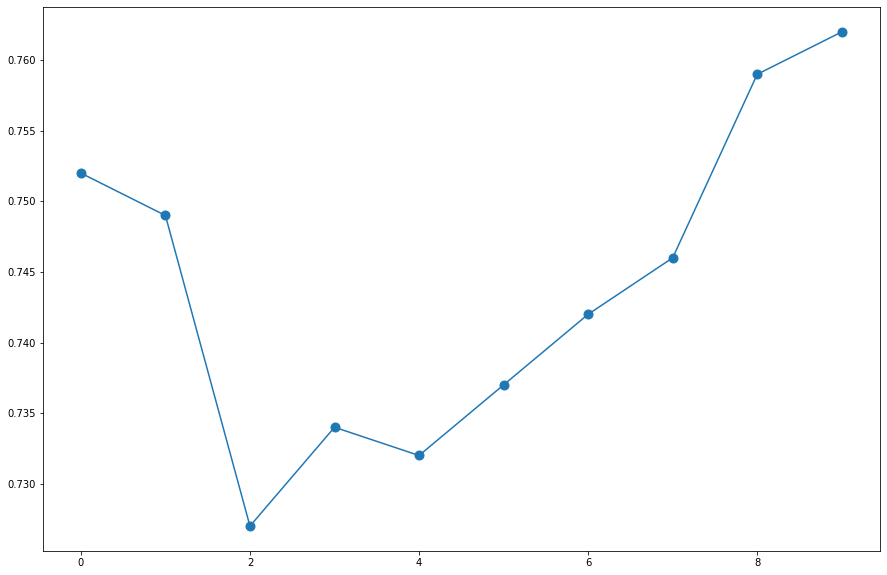

In [12]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

error_rate = []
k_accuracies = {}

for k in k_choices:
    k_accuracies[k] = []
    knn = knn_classifier.train(X_train, y_train)
    pred = knn_classifier.predict_labels(dists, k=k)
    num_correct = np.sum(pred == y_test)
    error_rate.append(np.mean(pred != y_test))
    # accuracy = float(num_correct) / X_train.shape[0]
    accuracy = float(num_correct)/num_test
    k_accuracies[k].append(accuracy)

plt.figure(figsize=(15,10))
plt.plot(error_rate, marker='o', markersize=9)

for k in sorted(k_accuracies):
    for accuracy in k_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

In [13]:
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_accuracies.items())])

best_k = k_choices[accuracies_mean.argmax()]

classifier = KNN()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct at k=%d=> accuracy: %f' % (num_correct, num_test, best_k, accuracy))

Got 273 / 1000 correct at k=5=> accuracy: 0.273000


# **Implementing Linear-Classifier with SVM/hinge loss**

In [14]:
def svm_loss(W, X, y, reg):
 
  dW = np.zeros(W.shape) # initialize the gradient as zero

  classes = W.shape[1]
  train = X.shape[0]
  loss = 0.0
  for i in range(train):
    scores = X[i].dot(W)
    correct_class_score = scores[y[i]]
    for j in range(classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1
      if margin > 0:
        loss += margin
        dW[:, y[i]] = dW[:, y[i]] - X[i] 
        dW[:,j] = dW[:,j] + X[i] 

  loss /= train
  dW = dW / train 

  # Add regularization to the loss.
  loss += reg * np.sum(W * W)
  dW = dW + reg * 2 * W 

  return loss, dW

In [15]:
W = np.random.randn(3073, 10) * 0.0001 

alpha = 1e-7
loss_history = []
for i in range(100):
  loss, grad = svm_loss(W,X_train,y_train,0.0000005)
  print("Loss for epoch {} is: {}".format(i,loss))
  loss_history.append(loss)
  W = W - alpha * grad


# loss, grad = svm_loss(W, X_train, y_train, 0.000021)
# print("loss: %f" % (loss))

Loss for epoch 0 is: 10.169367909079158
Loss for epoch 1 is: 10.897896475753011
Loss for epoch 2 is: 11.045152610778105
Loss for epoch 3 is: 11.544831749665594
Loss for epoch 4 is: 10.83607990613083
Loss for epoch 5 is: 10.96389558349763
Loss for epoch 6 is: 10.249866550946455
Loss for epoch 7 is: 10.819167103268642
Loss for epoch 8 is: 9.846730206870484
Loss for epoch 9 is: 10.33560696175929
Loss for epoch 10 is: 9.67570262763354
Loss for epoch 11 is: 10.02454964506774
Loss for epoch 12 is: 9.637890389989101
Loss for epoch 13 is: 9.6319629282536
Loss for epoch 14 is: 9.536507027211993
Loss for epoch 15 is: 9.30735144943046
Loss for epoch 16 is: 9.396355667394019
Loss for epoch 17 is: 8.971419803544444
Loss for epoch 18 is: 9.276217507066791
Loss for epoch 19 is: 8.687576940522021
Loss for epoch 20 is: 9.212444099994974
Loss for epoch 21 is: 8.50420786454794
Loss for epoch 22 is: 9.175370949055914
Loss for epoch 23 is: 8.407658516439222
Loss for epoch 24 is: 9.246816450658086
Loss for 

In [16]:
def svm_predict(W,images):
  preds = []
  for idx, i in enumerate(images):
    score = (np.dot(i.flatten().reshape(1,-1),W)).ravel()
    preds.append(np.argmax(score)+1)

  return preds

In [17]:
predictions = svm_predict(W,X_test)

In [18]:
svm_accuracy = np.mean(y_test == predictions)
print("Linear Classification with SVM accuracy: %f" % (svm_accuracy))

Linear Classification with SVM accuracy: 0.086000


In [19]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       103
           1       0.06      0.19      0.09        89
           2       0.02      0.02      0.02       100
           3       0.12      0.58      0.20       103
           4       0.00      0.00      0.00        90
           5       0.00      0.00      0.00        86
           6       0.09      0.03      0.04       112
           7       0.05      0.04      0.04       102
           8       0.00      0.00      0.00       106
           9       0.00      0.00      0.00       109
          10       0.00      0.00      0.00         0

    accuracy                           0.09      1000
   macro avg       0.03      0.08      0.04      1000
weighted avg       0.04      0.09      0.04      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

# **Implementing Linear-Classifier with SOFTMAX loss**

In [20]:
def softmax_loss(W, X, y, reg):
 
  loss = 0.0
  dW = np.zeros_like(W)
  scores = X.dot(W)
  num_train = X.shape[0]
  num_classes = W.shape[1]

  # Softmax Loss
  for i in range(num_train):
    f = scores[i] - np.max(scores[i])
    softmax = np.exp(f)/np.sum(np.exp(f))
    loss += -np.log(softmax[y[i]])
    # Weight Gradients
    for j in range(num_classes):
      dW[:,j] += X[i] * softmax[j]
    dW[:,y[i]] -= X[i]

  # Average
  loss /= num_train
  dW /= num_train

  # Regularization
  loss += reg * np.sum(W * W)
  dW += reg * 2 * W 

  return loss, dW

In [21]:
W = 0.001 * np.random.rand(3073,10)
b = 0.001 * np.random.rand(1,10)
alpha = 1e-7
loss_history = []
for i in range(100):
  loss, grad = softmax_loss(W,X_train,y_train,0)
  print("Loss for epoch {} is: {}".format(i,loss))
  loss_history.append(loss)
  W = W - alpha * grad

Loss for epoch 0 is: 4.4731855604005535
Loss for epoch 1 is: 3.133892988749683
Loss for epoch 2 is: 2.889050764031625
Loss for epoch 3 is: 2.7708060428233767
Loss for epoch 4 is: 2.685823293141975
Loss for epoch 5 is: 2.620442733139103
Loss for epoch 6 is: 2.570169610303053
Loss for epoch 7 is: 2.5335048178861035
Loss for epoch 8 is: 2.5090891564629563
Loss for epoch 9 is: 2.4940250752588073
Loss for epoch 10 is: 2.484521881590629
Loss for epoch 11 is: 2.4775911921440605
Loss for epoch 12 is: 2.471655088738511
Loss for epoch 13 is: 2.466092225218678
Loss for epoch 14 is: 2.460700203041872
Loss for epoch 15 is: 2.4554191392579607
Loss for epoch 16 is: 2.4502312394883705
Loss for epoch 17 is: 2.445130281320201
Loss for epoch 18 is: 2.44011314504702
Loss for epoch 19 is: 2.435177561166733
Loss for epoch 20 is: 2.4303215207112014
Loss for epoch 21 is: 2.4255431206907283
Loss for epoch 22 is: 2.420840522790055
Loss for epoch 23 is: 2.4162119416618846
Loss for epoch 24 is: 2.411655641030206


In [22]:
def softmax_predict(W,images):
  preds = []
  for idx, i in enumerate(images):
    score = (np.dot(i.flatten().reshape(1,-1),W)).ravel()
    preds.append(np.argmax(score)+1)

  return preds

In [23]:
softmax_preds = softmax_predict(W, X_test)

In [24]:
softmax_accuracy = np.mean(y_test == softmax_preds)

In [25]:
print("softmax accuracy: %f" %(softmax_accuracy))

softmax accuracy: 0.100000
